<a href="https://colab.research.google.com/github/lhb00/basic_pytorch_for_deeplearning/blob/main/basic_pytorch_for_deeplearning_theme_10~12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Theme 10. 시각화
####(1) 설명가능한 인공지능
##### 1. Class Activation Map

In [1]:
# 라이브러리 불러오기
# CIFAR10 이미지보다 사이즈가 큰 STL10 데이터 사용함.
# CAM의 가독성 확보를 위해 96X96 크기 이미지를 128X128로 늘려 데이터 활용함.
# STL10은 비행기, 새, 자동차, 고양이, 사슴, 개, 말, 원숭이, 배, 트럭을 클래스로 가짐
import numpy as np
from matplotlib import pyplot as plt
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [3]:
# 데이터 불러오기
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root = '/content/drive/MyDrive/deeplearning/data', split='train', download=True,
                                  transform=transform) # 96X96
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True)
testset = torchvision.datasets.STL10(root='/content/drive/MyDrive/deeplearning/data', split='test', download=True,
                                     transform=transform) # 96X96
testloader = torch.utils.data.DataLoader(testset, batch_size=40, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 모델 불러오기
# CAM은 모델 결과에 대한 이미지를 설명하는 것 => 이미 학습된 모델이 있어야함!
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/stl10_resnet18.pth'))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

In [5]:
# 정확도 확인
# 학습 정확도가 99%, 평가 정확도가 86%인 모델을 이용, CAM 결과를 산출
def acc(dataloader):
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for data in dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.detach(),1)
      total+=labels.size(0)
      correct+=(predicted==labels).sum().item()
  print('Accuracy: %d %%'%(100*correct/total))
acc(trainloader)
acc(testloader)

Accuracy: 99 %
Accuracy: 86 %


In [13]:
# CAM 구축
activation = {}
def get_activation(name):
  def hook(model,input,output):
    activation[name]=output.detach()
  return hook
# 위에서 정의된 hook을 포함한 함수 get_activation: register_forward_hook과 함께 사용, 모델의 특정 레이어에서의 피쳐맵을 추출할 수 있도록 도와주는 역할

In [14]:
def cam(dataset, img_sample, img_size): # 데이터 세트, 이미지 번호, 사이즈를 불러옴
  model.eval()
  with torch.no_grad():
    model.layer4[1].bn2.register_forward_hook(get_activation('final')) # 파이토치에서 제공하는 ResNet18의 마지막 합성곱 층 이름 : model.layer4[1].bn2 => register_forward_hook을 이용, 마지막 합성곱 층의 피쳐맵을 불러올 수 있도록 지정. 마지막 합성곱 층 이름을 final이라고 지음.
    data, label = dataset[img_sample] # CAM은 이미지를 하나씩 받아 클래스 별로 가중치와 피쳐맵을 곱함 => 이미지 하나를 불러오도록 함.
    data.unsqueeze_(0) # 이미지 한 장은 3차원 이미지, 모델의 입력 데이터는 배치사이즈를 포함하여 4차원을 요구=> unsqueeze_(0)을 통해 0번째 차원을 하나 늘려준다.([피쳐수, 너비, 높이]=>[1, 피쳐수, 너비, 높이])
    # 여기서 _인 인플레스 방식으로 data에 data.unsqueeze(0)를 하여 업데이트 하는 것을 의미.
    output = model(data.to(device)) # 모델의 예측값을 구함.
    _, prediction = torch.max(output,1)
    act = activation['final'].squeeze() # 마지막 합성곱 층의 피쳐맵을 불러오고 분류기의 가중치를 불러옴.
    w = model.fc.weight
    for idx in range(act.size(0)): # 피쳐맵 act[idx]와 해당 예측 클래스와 관련된 가중치 w[prediction.item()][idx]를 곱하여 누적
      if idx==0:
        tmp=act[idx]*w[prediction.item()][idx]
      else:
        tmp+=act[idx]*w[prediction.item()][idx]
    normalized_cam = tmp.cpu().numpy() # 계산된 CAM 이미지를 0~255 값으로 변환
    normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam)- np.min(normalized_cam))
    original_img = np.uint8((data[0][0] / 2 + 0.5)) * 255 # 원본 이미지를 불러옴.
    cam_img = cv2.resize(np.uint8(normalized_cam*255), dsize=(img_size, img_size)) # CAM 이미지를 원본 이미지와 동일한 크기로 리사이즈
  return cam_img, original_img, prediction, label # 원본 이미지, CAM 이미지, 예측 라벨, 실제 라벨 반환

In [15]:
# CAM 결과 산출 함수 정의
def plot_cam(dataset, img_size, start): # 데이터 세트, 이미지 크기, 이미지 시작 번호를 받음.
  end = start + 20 # 시작 번호로부터 20장의 CAM 출력
  fig, axs = plt.subplots(2, (end-start+1)//2, figsize=(20,4)) # 전체 표 및 부분 그래프에 대한 크기, 설정 및 부분 그래프 간의 공백 조절
  fig.subplots_adjust(hspace=.01, wspace=.01) 
  axs = axs.ravel()
  cls = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck'] # STL10의 클래스명 정의
  for i in range(start, end): # 이미지를 하나씩 불러옴.
    cam_img, original_img, prediction, label = cam(dataset, i, img_size) # cam 함수를 작동시킴.
    if prediction==label: # 이미지의 클래스를 표현할 때 정확한 예측은 라벨의 배경이 흰색, 잘못된 예측은 빨간색
      color = 'white'
    else:
      color = 'red'
    axs[i-start].imshow(original_img, cmap='gray') # 원본 이미지는 흑백으로 바꾸고 CAM 결과는 jet을 이용해 히트맵으로 표현. 이때 alpha는 히트맵의 밝기 값.
    axs[i-start].imshow(cam_img, cmap='jet', alpha=.4)
    axs[i-start].text(5,5,cls[prediction],bbox={'facecolor':color, 'pad':5}) # 라벨 주석을 달아주고 좌표 표시는 모두 없앰.
  plt.show()

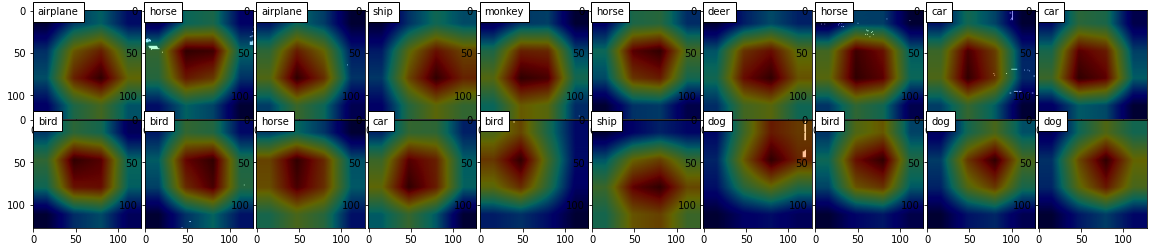

In [16]:
# CAM 결과 산출
# 히트맵에서의 빨간 부분은 결과에 크게 영향을 미쳤다는 뜻, 파란색에 가까울수록 예측에 덜 영향을 주는 영역
# 학습 데이터에 대한 정확도는 99%, 객체에 히트맵이 잘 집중되는 것을 알 수 있음.
# 반면, 평가 데이터에서 잘못 예측된 세번째 이미지를 보면 히트맵이 객체에 집중 못하고 있음. 1, 11번째 이미지는 객체 위치를 파악, 정확한 특징 추출 못함.
plot_cam(trainset, 128, 10)

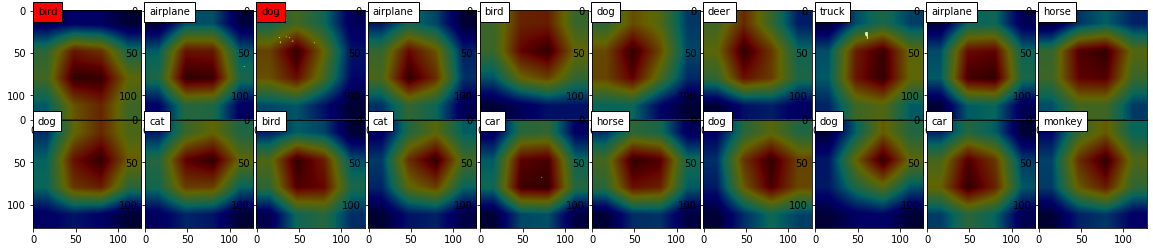

In [17]:
plot_cam(testset, 128, 10)

####(2)차원 축소 기법
#####1. t-distributed Stochastic Neighbor Embedding

In [18]:
# 합성곱 신경망을 거쳐 나온 고차원의 피쳐맵 분석을 위해 사용되는 차원 축소 기법 중 하나인 t-SNE를 살펴봄.
# 라이브러리 불러오기
from sklearn.manifold import TSNE # sklearn에서 제공하는 TSNE를 불러옴.
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn

In [20]:
# 데이터 불러오기
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/deeplearning/data', train=False, download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=16)

Files already downloaded and verified


In [22]:
# 모델 불러오기
# 합성곱 신경망이 추출한 피쳐맵들이 어떠한 분포를 가지고 있는지, 어떤 이미지들이 클래스의 경계부분 들이 있는지를 파악하는 것은 중요 => 일반적으로 마지막 합성곱 층에서 추출된 피쳐맵을 가지고 분포를 그림.
# => CAM 코드에서 사용했던 hook을 사용, 피쳐맵을 추출할수도 있지만, 코드를 간소하기 위해 분류기 자체를 항등 함수 f(x)=x로 변경, 모델에서의 출력값을 피쳐맵으로 뽑아낼 수 있음.
class Identity(nn.Module): # 항등 함수에 해당하는 Identity()를 작성.
  def __init__(self):
    super(Identity, self).__init__()
  def forward(self,x):
    return x
model = torchvision.models.resnet18(pretrained=False) # t-SNE는 평가 결과의 일부 => 이미 학습된 모델을 가지고 진행
# => 저장된 사전 학습된 모델 변수 적용을 위해 모델을 먼저 불러온 뒤 model.fc를 항등 함수로 변경(물론 매 학습 epoch마다 t_SNE 좌표를 산출하여 좌표 변화 확인도 가능.)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/deeplearning/models/cifar10_resnet18.pth'))
model.fc = Identity()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [23]:
# 피쳐맵과 예측값 저장
actual = []
deep_features = []
model.eval()
with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    features = model(images) # 모델의 분류기를 제거 했음 =>분류기의 이전 값인 전역 평균풀링 값이 features가 됨. 
    # => model로부터 나온 각 이미지의 피쳐 크기 : 512, 512차원인 벡터가 됨(if 전역 평균풀링 사용 X & 사각형 or  육면체 형태의 피쳐맵을 얻었다면 일렬로 편 벡터 형태로 deep_features를 저장)
    deep_features+=features.cpu().tolist() # 각 이미지의 deep_features와 라벨을 저장
    actual+=labels.cpu().tolist()

In [24]:
# t-SNE 정의
# t-SNE는 sklearn에서 제공하는 라이브러리를 사용, 매우 간단하게 구현 가능
tsne = TSNE(n_components=2, random_state=0) # 먼저 차원 축소의 차원 수를 정함. 우리는 그래프를 그려야하므로 n_components를 3 이하로 정해야함.
# => n_components=2는 512차원의 모든 deep_features 값들을 2차원 좌표로 차원 축소한다는 뜻.
# 또한 t-SNE는 차원 축소 시 임의의 점을 기준으로 잡고 저차원 임베딩을 함. => random_state를 임의로 정해줌, random_state에 따라 좌표값이 달라질 수 있지만 분포의 경향성을 보는데 큰 지장은 X.
# But, 기준에 따라 차원 축소 좌표가 달라짐 => 값 자체를 사용하여 다른 데이터의 분포들과 비교하는 것은 무리 있음.
cluster = np.array(tsne.fit_transform(np.array(deep_features))) # tsne.fit_transform을 통하여 차원 축소 데이터 생성 => cluster는 각 이미지에 대응하는 2차원 벡터들의 모임, cluster의 0열은 x좌표, 1열은 y좌표가 됨.
actual = np.array(actual) # actual을 넘파이 배열로 변경

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


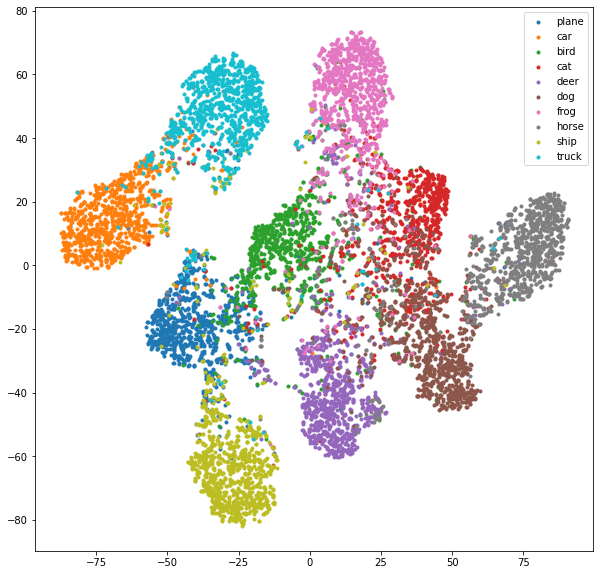

In [27]:
# t-SNE 그래프 그리기
plt.figure(figsize=(10,10))
cifar = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i, label in zip(range(10), cifar):
  idx = np.where(actual==i)
  plt.scatter(cluster[idx,0], cluster[idx,1], marker='.', label=label)
plt.legend()
plt.show()

#####3. 주성분 분석

In [29]:
# 주성분 분석(PCA) : 대표적인 차원 축소 기법
# t-SNE의 차원 축소는 PCA보다 본래 특성을 더 훼손, 차원 축소된 값을 활용하는데 한계 O, But, PCA는 데이터의 고유값을 이용해 분석하므로 클러스터링/데이터 분석에 활용도 큼.
# PCA 정의
# PCA도 sklearn을 통해 쉽게 구현 가능. & pca.explained_variance_ratio_를 통해 영향도를 파악 가능.
# 이 예시에서는 2차원으로 축소 했으므로 2개의 영향도를 보여줌. 두 영향도의 합이 약 0.35: 35%의 영향도를 유지한다는 의미 => 원래 차원에서의 피쳐 특징은 소실됐을 가능성 큼.
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
cluster = np.array(pca.fit_transform(np.array(deep_features)))
print(pca.explained_variance_ratio_)

[0.20507802 0.15242794]


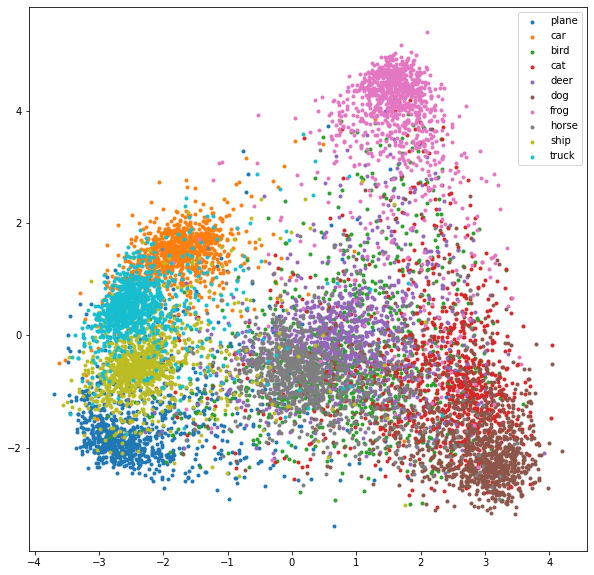

In [31]:
# PCA 그래프 그리기
# 다음은 t-SNE와 동일한 과정으로 그래프 그림.
plt.figure(figsize=(10,10))

for i, label in zip(range(10), cifar):
  idx = np.where(actual==i)
  plt.scatter(cluster[idx,0], cluster[idx,1], marker='.', label=label)
plt.legend()
plt.show()

###Theme 11. 메타 학습
####(2) MAML - 회귀 문제